# **`Image Super-Resolution Using GANs`**

In [1]:
!pip install torch torchvision pillow tqdm

# Create directory for dataset
!mkdir -p /content/data/train

# Download DIV2K High-Resolution training images from official ETH Zurich site
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip -O /content/DIV2K_train_HR.zip

# Unzip dataset
!unzip -q /content/DIV2K_train_HR.zip -d /content/data/train


--2025-11-11 10:59:22--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip [following]
--2025-11-11 10:59:22--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘/content/DIV2K_train_HR.zip’

/content/DIV2K_trai 100%[===================>]   3.29G  22.5MB/s    in 2m 33s  

2025-11-11 11:01:56 (22.0 MB/s) - ‘/content/DIV2K_train_HR.zip’ saved [3530603713/3530603713]



# **Imports and Dataset Loader**

In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class SRDataset(Dataset):
    def __init__(self, img_folder, hr_size=96):
        self.img_files = [os.path.join(img_folder, f) for f in os.listdir(img_folder) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
        self.hr_size = hr_size
        self.hr_transform = transforms.Compose([
            transforms.Resize((hr_size, hr_size)),
            transforms.ToTensor()
        ])
        self.lr_transform = transforms.Compose([
            transforms.Resize((hr_size//4, hr_size//4)),
            transforms.Resize((hr_size, hr_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img = Image.open(self.img_files[idx]).convert('RGB')
        hr_img = self.hr_transform(img)
        lr_img = self.lr_transform(img)
        return lr_img, hr_img

def get_loader(img_folder, batch_size=8, hr_size=96):
    dataset = SRDataset(img_folder, hr_size)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


# **SRGAN Model (Generator + Discriminator)**

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, 1, 1),
            nn.BatchNorm2d(channels),
            nn.PReLU(),
            nn.Conv2d(channels, channels, 3, 1, 1),
            nn.BatchNorm2d(channels)
        )
    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, in_channels=3, num_blocks=16):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, 64, 9, 1, 4),
            nn.PReLU()
        )
        blocks = [ResidualBlock(64) for _ in range(num_blocks)]
        self.res_blocks = nn.Sequential(*blocks)
        self.conv = nn.Sequential(
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64)
        )
        self.upsample = nn.Sequential(
            nn.Conv2d(64, 256, 3, 1, 1),
            nn.PixelShuffle(2),  # doubles H, W
            nn.PReLU(),
            nn.Conv2d(64, 256, 3, 1, 1),
            nn.PixelShuffle(2),
            nn.PReLU()
        )
        self.final = nn.Conv2d(64, in_channels, 9, 1, 4)

    def forward(self, x):
        x = self.initial(x)
        res = self.res_blocks(x)
        x = self.conv(res) + x
        x = self.upsample(x)
        return self.final(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        def conv_block(in_feat, out_feat, stride):
            return [
                nn.Conv2d(in_feat, out_feat, 3, stride, 1),
                nn.BatchNorm2d(out_feat),
                nn.LeakyReLU(0.2, inplace=True)
            ]
        layers = [nn.Conv2d(in_channels, 64, 3, 1, 1), nn.LeakyReLU(0.2)]
        layers += conv_block(64, 64, 2)
        layers += conv_block(64, 128, 1)
        layers += conv_block(128, 128, 2)
        layers += conv_block(128, 256, 1)
        layers += conv_block(256, 256, 2)
        layers += conv_block(256, 512, 1)
        layers += conv_block(512, 512, 2)
        layers += [
            nn.Flatten(),
            nn.Linear(512 * 6 * 6, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


# **Training Loop**

In [5]:
# ==========================================
# SRGAN TRAINING - COLAB SAFE VERSION
# NO argparse, NO terminal args, NO Jupyter crashes
# ==========================================

import os
import math
import glob
import random
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import torchvision.transforms as T
import torchvision.utils as vutils
from tqdm import tqdm

# ---------------------------------------
# Utils
# ---------------------------------------

def set_seed(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def save_sample(tensor, out_dir, epoch, prefix="sample"):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    tensor = torch.clamp(tensor, 0.0, 1.0)
    vutils.save_image(tensor, out_dir / f"{prefix}_epoch{epoch:03d}.png", nrow=4)

# ---------------------------------------
# Dataset Loader - LR/HR Pair Creator
# ---------------------------------------

class DIV2K(Dataset):
    def __init__(self, folder, hr_size=96, scale=4):
        super().__init__()
        self.paths = sorted(
            glob.glob(os.path.join(folder, "*"))
        )
        self.hr_size = hr_size
        self.lr_size = hr_size // scale

        self.to_tensor = T.ToTensor()
        self.crop = T.RandomCrop(hr_size)
        self.down = T.Resize(self.lr_size, T.InterpolationMode.BICUBIC)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")

        hr = self.crop(img)
        lr = self.down(hr)

        return self.to_tensor(lr), self.to_tensor(hr)

def get_loader(folder, batch=8, hr_size=96, scale=4):
    ds = DIV2K(folder, hr_size, scale)
    return DataLoader(ds, batch_size=batch, shuffle=True, num_workers=2, drop_last=True)

# ---------------------------------------
# Model: Generator (SRResNet-like)
# ---------------------------------------

class ResidualBlock(nn.Module):
    def __init__(self, nf=64):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(nf, nf, 3, 1, 1),
            nn.BatchNorm2d(nf),
            nn.PReLU(),
            nn.Conv2d(nf, nf, 3, 1, 1),
            nn.BatchNorm2d(nf),
        )

    def forward(self, x):
        return x + self.block(x)

class UpsampleBlock(nn.Module):
    def __init__(self, nf, scale):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(nf, nf * (scale ** 2), 3, 1, 1),
            nn.PixelShuffle(scale),
            nn.PReLU(),
        )

    def forward(self, x):
        return self.block(x)

class Generator(nn.Module):
    def __init__(self, scale=4, n_blocks=16, nf=64):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(3, nf, 9, 1, 4), nn.PReLU())

        self.residual = nn.Sequential(*[ResidualBlock(nf) for _ in range(n_blocks)])
        self.res_out = nn.Sequential(nn.Conv2d(nf, nf, 3, 1, 1), nn.BatchNorm2d(nf))

        up_blocks = []
        for _ in range(int(math.log2(scale))):
            up_blocks.append(UpsampleBlock(nf, 2))
        self.upsample = nn.Sequential(*up_blocks)

        self.conv_last = nn.Conv2d(nf, 3, 9, 1, 4)

    def forward(self, x):
        x1 = self.conv1(x)
        xr = self.residual(x1)
        xr = self.res_out(xr)
        x = x1 + xr
        x = self.upsample(x)
        x = self.conv_last(x)
        return torch.sigmoid(x)

# ---------------------------------------
# Model: Discriminator
# ---------------------------------------

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        def block(in_c, out_c, stride):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, stride, 1),
                nn.BatchNorm2d(out_c),
                nn.LeakyReLU(0.2)
            )

        layers = [
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.LeakyReLU(0.2),

            block(64, 64, 2),
            block(64, 128, 1),

            block(128, 128, 2),
            block(128, 256, 1),

            block(256, 256, 2),
            block(256, 512, 1),

            block(512, 512, 2),
        ]

        self.features = nn.Sequential(*layers)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# ---------------------------------------
# Training Function
# ---------------------------------------

def train_srgan(
    img_folder="/content/data/train/DIV2K_train_HR",
    out_dir="./outputs",
    hr_size=96,
    scale=4,
    batch=8,
    epochs=5,
    lr_g=1e-4,
    lr_d=1e-4,
):

    set_seed()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load data
    loader = get_loader(img_folder, batch, hr_size, scale)

    # Models
    G = Generator(scale).to(device)
    D = Discriminator().to(device)

    # Optimizers
    opt_g = optim.Adam(G.parameters(), lr=lr_g)
    opt_d = optim.Adam(D.parameters(), lr=lr_d)

    bce = nn.BCELoss()
    mse = nn.MSELoss()

    Path(out_dir).mkdir(exist_ok=True)

    for epoch in range(1, epochs + 1):

        g_loss_sum = 0
        d_loss_sum = 0

        for lr_img, hr_img in tqdm(loader, desc=f"Epoch {epoch}/{epochs}"):

            lr_img = lr_img.to(device)
            hr_img = hr_img.to(device)

            # --------------------
            # Train Discriminator
            # --------------------
            fake_hr = G(lr_img).detach()

            real_pred = D(hr_img)
            fake_pred = D(fake_hr)

            d_real = bce(real_pred, torch.ones_like(real_pred))
            d_fake = bce(fake_pred, torch.zeros_like(fake_pred))
            d_loss = (d_real + d_fake) / 2

            opt_d.zero_grad()
            d_loss.backward()
            opt_d.step()

            # --------------------
            # Train Generator
            # --------------------
            fake_hr = G(lr_img)
            g_fake_pred = D(fake_hr)

            adv_loss = bce(g_fake_pred, torch.ones_like(g_fake_pred))
            content_loss = mse(fake_hr, hr_img)
            g_loss = content_loss + 1e-3 * adv_loss

            opt_g.zero_grad()
            g_loss.backward()
            opt_g.step()

            g_loss_sum += g_loss.item()
            d_loss_sum += d_loss.item()

        print(f"Epoch {epoch} | G Loss: {g_loss_sum/len(loader):.4f} | D Loss: {d_loss_sum/len(loader):.4f}")

        # Save generated sample
        with torch.no_grad():
            lr_sample, hr_sample = next(iter(loader))
            lr_sample = lr_sample.to(device)
            fake_sample = G(lr_sample).cpu()

            save_sample(fake_sample, out_dir, epoch, "fake")
            save_sample(hr_sample, out_dir, epoch, "real")

        torch.save(G.state_dict(), f"{out_dir}/G_epoch{epoch}.pth")
        torch.save(D.state_dict(), f"{out_dir}/D_epoch{epoch}.pth")

    print("✅ Training Complete!")

# ==========================================
# ✅ RUN TRAINING HERE (NO ARGPARSE NEEDED)
# ==========================================

train_srgan(
    img_folder="/content/data/train/DIV2K_train_HR",
    out_dir="/content/srgan_out",
    hr_size=96,
    scale=4,
    batch=4,
    epochs=5
)


Epoch 1/5: 100%|██████████| 200/200 [01:04<00:00,  3.09it/s]

Epoch 1 | G Loss: 0.0301 | D Loss: 0.3784



Epoch 2/5: 100%|██████████| 200/200 [01:04<00:00,  3.10it/s]

Epoch 2 | G Loss: 0.0156 | D Loss: 0.3234



Epoch 3/5: 100%|██████████| 200/200 [01:04<00:00,  3.12it/s]

Epoch 3 | G Loss: 0.0123 | D Loss: 0.3415



Epoch 4/5: 100%|██████████| 200/200 [01:02<00:00,  3.17it/s]

Epoch 4 | G Loss: 0.0111 | D Loss: 0.2964



Epoch 5/5: 100%|██████████| 200/200 [01:04<00:00,  3.10it/s]

Epoch 5 | G Loss: 0.0105 | D Loss: 0.2555


✅ Training Complete!


# **Inference**

In [6]:
# ============================================================
# SRGAN INFERENCE - COLAB SAFE (NO argparse)
# ============================================================

import torch
import torch.nn as nn
import torchvision.transforms as T
from PIL import Image
from pathlib import Path


# ------------------------------------------------------------
# ✅ SAME GENERATOR AS TRAINING (must match exactly)
# ------------------------------------------------------------

class ResidualBlock(nn.Module):
    def __init__(self, nf=64):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(nf, nf, 3, 1, 1),
            nn.BatchNorm2d(nf),
            nn.PReLU(),
            nn.Conv2d(nf, nf, 3, 1, 1),
            nn.BatchNorm2d(nf),
        )

    def forward(self, x):
        return x + self.block(x)


class UpsampleBlock(nn.Module):
    def __init__(self, nf, scale):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(nf, nf * (scale ** 2), 3, 1, 1),
            nn.PixelShuffle(scale),
            nn.PReLU(),
        )

    def forward(self, x):
        return self.block(x)


class Generator(nn.Module):
    def __init__(self, scale=4, n_blocks=16, nf=64):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(3, nf, 9, 1, 4), nn.PReLU())

        self.residual = nn.Sequential(*[ResidualBlock(nf) for _ in range(n_blocks)])
        self.res_out = nn.Sequential(nn.Conv2d(nf, nf, 3, 1, 1), nn.BatchNorm2d(nf))

        up_blocks = []
        import math
        for _ in range(int(math.log2(scale))):
            up_blocks.append(UpsampleBlock(nf, 2))
        self.upsample = nn.Sequential(*up_blocks)

        self.conv_last = nn.Conv2d(nf, 3, 9, 1, 4)

    def forward(self, x):
        x1 = self.conv1(x)
        xr = self.residual(x1)
        xr = self.res_out(xr)
        x = x1 + xr
        x = self.upsample(x)
        x = self.conv_last(x)
        return torch.clamp(torch.sigmoid(x), 0.0, 1.0)


# ------------------------------------------------------------
# ✅ LOAD IMAGE
# ------------------------------------------------------------

def load_image(path):
    img = Image.open(path).convert("RGB")
    return img


# ------------------------------------------------------------
# ✅ SAVE IMAGE
# ------------------------------------------------------------

def save_image(tensor, path):
    img = T.ToPILImage()(tensor.squeeze(0).cpu().clamp(0, 1))
    img.save(path)


# ------------------------------------------------------------
# ✅ SRGAN INFERENCE FUNCTION
# ------------------------------------------------------------

def srgan_infer(weights_path, input_path, output_path, scale=4):
    """
    weights_path : .pth file of trained Generator
    input_path   : single image OR folder
    output_path  : folder for output
    scale        : 4 (default)
    """

    # Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    gen = Generator(scale).to(device).eval()

    # Load weights
    gen.load_state_dict(torch.load(weights_path, map_location=device))
    print("✅ Loaded Generator weights")

    # Normalize
    to_tensor = T.ToTensor()

    # Input paths
    in_path = Path(input_path)

    if in_path.is_file():
        img_paths = [in_path]
    else:
        img_paths = list(in_path.glob("*"))

    # Output folder
    out_dir = Path(output_path)
    out_dir.mkdir(parents=True, exist_ok=True)

    # Inference
    for img_path in img_paths:
        img = load_image(img_path)
        lr_tensor = to_tensor(img).unsqueeze(0).to(device)

        with torch.no_grad():
            sr = gen(lr_tensor)

        out_path = out_dir / f"{img_path.stem}_SRx{scale}.png"
        save_image(sr, out_path)

        print(f"✅ Saved: {out_path}")

    print("\n✅ SRGAN inference complete!")


# ============================================================
# ✅ HOW TO USE (EXAMPLE)
# ============================================================

# srgan_infer(
#     weights_path="/content/srgan_out/G_epoch5.pth",
#     input_path="/content/test_image.png",
#     output_path="/content/sr_outputs",
#     scale=4
# )


In [8]:
# ------------------------------------------------------------
# ✅ TILED INFERENCE (FOR BIG IMAGES, NO OOM)
# ------------------------------------------------------------

def srgan_infer(weights_path, input_path, output_path, scale=4, tile=128, tile_overlap=16):
    """
    weights_path : generator .pth file
    input_path   : LR image
    output_path  : save location
    scale        : upscale factor (4)
    tile         : crop size to process at once (128–256 recommended)
    tile_overlap : extra padding to avoid seams
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    gen = Generator(scale).to(device).eval()
    gen.load_state_dict(torch.load(weights_path, map_location=device))

    print("✅ Loaded SRGAN Generator weights")

    # Load LR image
    img = Image.open(input_path).convert("RGB")
    to_tensor = T.ToTensor()
    lr = to_tensor(img).unsqueeze(0).to(device)

    b, c, h, w = lr.shape

    # Output tensor
    sr = torch.zeros((1, 3, h * scale, w * scale), dtype=torch.float32, device=device)
    weight = torch.zeros_like(sr)

    # Process tiles row by row
    for y in range(0, h, tile):
        for x in range(0, w, tile):

            y1 = y
            x1 = x
            y2 = min(y + tile + tile_overlap, h)
            x2 = min(x + tile + tile_overlap, w)

            lr_tile = lr[:, :, y1:y2, x1:x2]

            with torch.no_grad():
                sr_tile = gen(lr_tile)

            # Coordinates in SR space
            sy1 = y1 * scale
            sx1 = x1 * scale
            sy2 = y2 * scale
            sx2 = x2 * scale

            sr[:, :, sy1:sy2, sx1:sx2] += sr_tile
            weight[:, :, sy1:sy2, sx1:sx2] += 1

    sr = sr / weight
    sr = torch.clamp(sr, 0, 1)

    save_image(sr, output_path)
    print(f"✅ Super-resolved image saved: {output_path}")

    return sr


In [9]:
lr_path = download_test_image("/content/test.png")

sr_tensor = srgan_infer(
    weights_path="/content/srgan_out/G_epoch5.pth",
    input_path=lr_path,
    output_path="/content/SRGAN_result.png",
    scale=4,
    tile=128,         # <-- CRUCIAL
    tile_overlap=16   # smooth seams
)


✅ Test image downloaded: /content/test.png
✅ Loaded SRGAN Generator weights
✅ Super-resolved image saved: /content/SRGAN_result.png


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (164256192 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


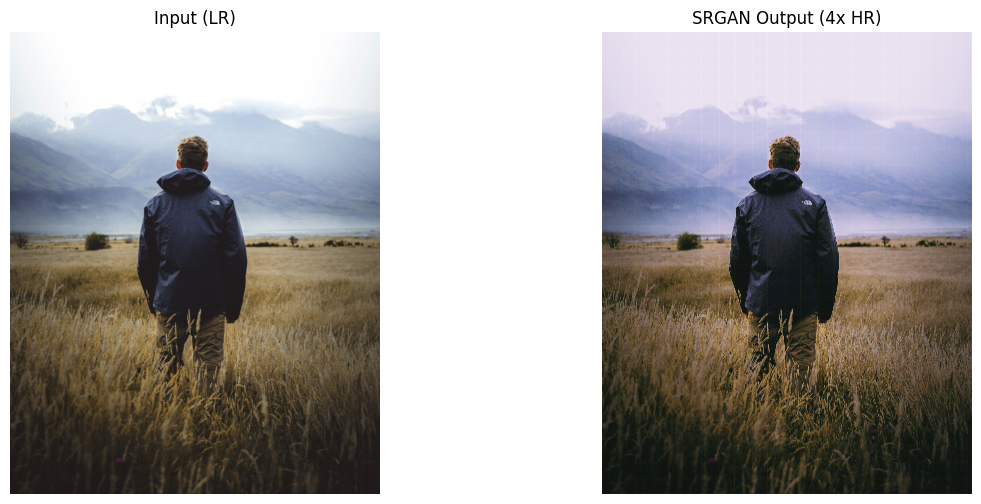

In [10]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Paths
lr_img_path = "/content/test.png"
sr_img_path = "/content/SRGAN_result.png"

# Load
lr_img = np.array(Image.open(lr_img_path))
sr_img = np.array(Image.open(sr_img_path))

# Plot
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.title("Input (LR)")
plt.imshow(lr_img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("SRGAN Output (4x HR)")
plt.imshow(sr_img)
plt.axis("off")

plt.show()


📤 Please upload your image file...


Saving lr.jpeg to lr.jpeg
✅ Image uploaded: lr.jpeg
✅ Loaded SRGAN Generator weights
✅ Super-resolved image saved: /content/my_photo_SRx4.png


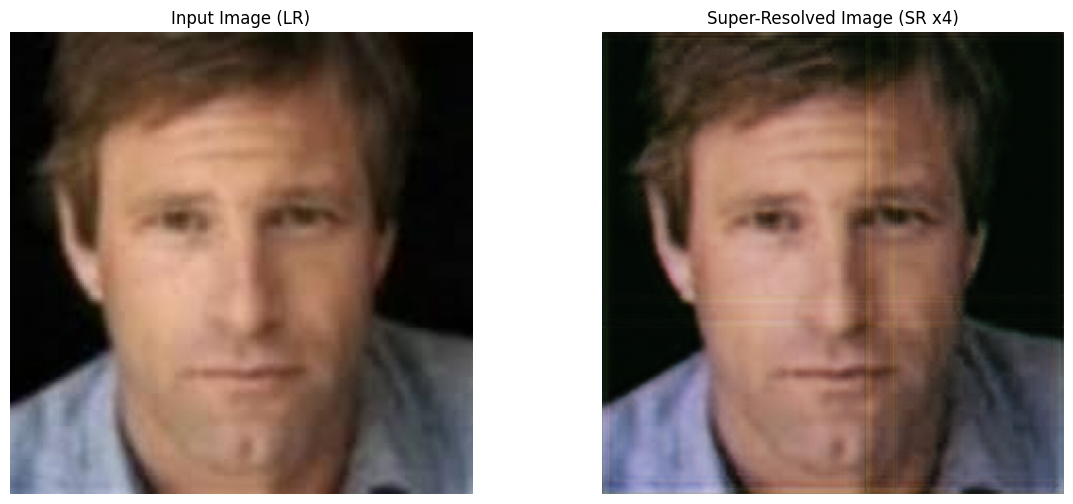

In [12]:
# =============================================================
# FULL SRGAN INFERENCE WITH YOUR OWN PHOTO (COLAB SAFE)
# Upload → Super-resolve → Display LR vs SR
# =============================================================

import torch
import torch.nn as nn
import torchvision.transforms as T
from PIL import Image
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files


# ------------------------------------------------------------
# ✅ SRGAN GENERATOR (Same as training)
# ------------------------------------------------------------
class ResidualBlock(nn.Module):
    def __init__(self, nf=64):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(nf, nf, 3, 1, 1),
            nn.BatchNorm2d(nf),
            nn.PReLU(),
            nn.Conv2d(nf, nf, 3, 1, 1),
            nn.BatchNorm2d(nf),
        )

    def forward(self, x):
        return x + self.block(x)

class UpsampleBlock(nn.Module):
    def __init__(self, nf, scale):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(nf, nf * (scale ** 2), 3, 1, 1),
            nn.PixelShuffle(scale),
            nn.PReLU()
        )

    def forward(self, x):
        return self.block(x)

class Generator(nn.Module):
    def __init__(self, scale=4, n_blocks=16, nf=64):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(3, nf, 9, 1, 4), nn.PReLU())

        self.residual = nn.Sequential(*[ResidualBlock(nf) for _ in range(n_blocks)])
        self.res_out = nn.Sequential(nn.Conv2d(nf, nf, 3, 1, 1), nn.BatchNorm2d(nf))

        import math
        up_blocks = []
        for _ in range(int(math.log2(scale))):
            up_blocks.append(UpsampleBlock(nf, 2))
        self.upsample = nn.Sequential(*up_blocks)

        self.conv_last = nn.Conv2d(nf, 3, 9, 1, 4)

    def forward(self, x):
        x1 = self.conv1(x)
        xr = self.residual(x1)
        xr = self.res_out(xr)
        x = x1 + xr
        x = self.upsample(x)
        x = self.conv_last(x)
        return torch.clamp(torch.sigmoid(x), 0.0, 1.0)


# ------------------------------------------------------------
# ✅ Tiled Inference — Prevents CUDA OOM
# ------------------------------------------------------------
def srgan_infer(weights_path, input_path, output_path, scale=4, tile=128, tile_overlap=16):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load generator
    gen = Generator(scale).to(device).eval()
    gen.load_state_dict(torch.load(weights_path, map_location=device))
    print("✅ Loaded SRGAN Generator weights")

    # Load low-res image
    img = Image.open(input_path).convert("RGB")
    to_tensor = T.ToTensor()
    lr = to_tensor(img).unsqueeze(0).to(device)

    b, c, h, w = lr.shape

    # Prepare output (HR)
    sr = torch.zeros((1, 3, h * scale, w * scale), dtype=torch.float32, device=device)
    weight = torch.zeros_like(sr)

    # Tile processing
    for y in range(0, h, tile):
        for x in range(0, w, tile):
            y1, x1 = y, x
            y2 = min(y + tile + tile_overlap, h)
            x2 = min(x + tile + tile_overlap, w)

            lr_tile = lr[:, :, y1:y2, x1:x2]

            with torch.no_grad():
                sr_tile = gen(lr_tile)

            sy1 = y1 * scale
            sx1 = x1 * scale
            sy2 = y2 * scale
            sx2 = x2 * scale

            sr[:, :, sy1:sy2, sx1:sx2] += sr_tile
            weight[:, :, sy1:sy2, sx1:sx2] += 1

    sr = sr / weight
    sr = torch.clamp(sr, 0, 1)

    # Save SR result
    out_img = T.ToPILImage()(sr.squeeze(0).cpu())
    out_img.save(output_path)
    print(f"✅ Super-resolved image saved: {output_path}")

    return sr


# ------------------------------------------------------------
# ✅ 1. Upload Your Own Image
# ------------------------------------------------------------
print("📤 Please upload your image file...")
uploaded = files.upload()

input_path = list(uploaded.keys())[0]
print(f"✅ Image uploaded: {input_path}")


# ------------------------------------------------------------
# ✅ 2. Run SRGAN on Your Image
# ------------------------------------------------------------
weights_path = "/content/srgan_out/G_epoch5.pth"  # <-- CHANGE IF NEEDED
output_path = "/content/my_photo_SRx4.png"

sr_tensor = srgan_infer(
    weights_path=weights_path,
    input_path=input_path,
    output_path=output_path,
    scale=4,
    tile=128,
    tile_overlap=16
)


# ------------------------------------------------------------
# ✅ 3. Show LR vs SR side-by-side
# ------------------------------------------------------------
lr_img = np.array(Image.open(input_path))
sr_img = np.array(Image.open(output_path))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.title("Input Image (LR)")
plt.imshow(lr_img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Super-Resolved Image (SR x4)")
plt.imshow(sr_img)
plt.axis("off")

plt.show()
